In [1]:
import torch
import torch.nn.functional as F
import numpy as np
from torch.autograd import Variable
from scipy.stats import multivariate_normal
np.cat = np.concatenate

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns

from tqdm import tqdm_notebook as tqdm

In [2]:
torch.__version__

'0.4.0'

In [3]:
def sample(mu, var, nb_samples=500):
    """
    Return a tensor of (nb_samples, features), sampled
    from the parameterized gaussian.
    
    :param mu: torch.Tensor of the means
    :param var: torch.Tensor of variances (NOTE: zero covars.)
    """
    out = []
    for i in range(nb_samples):
        out += [
            torch.normal(mu, var.sqrt()).unsqueeze(0)
        ]
    return torch.cat(out, dim=0)

In [4]:
# generate some clusters
cluster1 = sample(
    torch.Tensor([2.5, 2.5]),
    torch.Tensor([1.2, .8])
)

cluster2 = sample(
    torch.Tensor([7.5, 7.5]),
    torch.Tensor([.75, .5])
)

cluster3 = sample(
    torch.Tensor([8, 1.5]),
    torch.Tensor([.6, .8])
)

In [5]:
def plot_2d_sample(sample):
    sample_np = sample.numpy()
    x = sample_np[:, 0]
    y = sample_np[:, 1]
    plt.scatter(x, y)

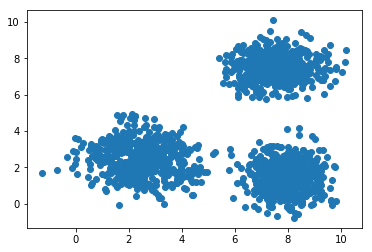

In [6]:
# create the dummy dataset, by combining the clusters.
X = torch.cat([cluster1, cluster2, cluster3])
plot_2d_sample(X)

In [7]:
def initialize(data, k, var=1):
    """
    Randomly initialize the parameters for `k` gaussians.
    
    :param data: design matrix (examples, features)
    :param k: number of gaussians
    :param var: initial variance
    """
    
    # choose k points from data to initialize means
    m = data.size(0)
    idxs = Variable(torch.from_numpy(
        np.random.choice(m, k, replace=False)))
    mu = data[idxs]
    
    # uniform sampling for means and variances
    var = Variable(torch.Tensor(k, d).fill_(var))
    
    # equal priors
    pi = Variable(torch.Tensor(k).fill_(1)) / k
    
    return mu, var, pi

In [8]:
def get_k_likelihoods(X, mu, var):
    """
    Compute the densities of each data point under the parameterised gaussians.
    
    :param X: design matrix (examples, features)
    :param mu: the component means (K, features)
    :param var: the component variances (K, features)
    :return: relative likelihoods (K, examples)
    """
    
    if var.data.eq(0).any():
        raise Exception('variances must be nonzero')
    
    # get the trace of the inverse covar. matrix
    covar_inv = 1. /  var # (K, features)
    
    # compute the coefficient
    det = (2 * np.pi * var).prod(dim=1) # (K)
    coeff = 1. / det.sqrt() # (K)
    
    # tile the design matrix `K` times on the batch dimension 
    K = mu.size(0)
    X = X.unsqueeze(0).repeat(K, 1, 1)
    
    # calculate the exponent
    a = (X - mu.unsqueeze(1)) # (K, examples, features)
    exponent = a ** 2 @ covar_inv.unsqueeze(2)
    exponent = -0.5 * exponent
    
    # compute probability density
    P = coeff.view(K, 1, 1) * exponent.exp()
    
    # remove final singleton dimension and return
    return P.squeeze(2)

In [9]:
def np_(var):
    """ helper fn for var -> numpy"""
    return var.data.numpy()

def test_likelihood_fn():
    """
    Checks that the computed densities match those given
    by the scipy implementation.
    """
    X = Variable(torch.randn(4, 3))

    mu = Variable(torch.Tensor([
        [0.3, -0.1, 0.4],
        [0.1, -0.2, 0.7]
    ]))

    var = Variable(torch.Tensor([
        [0.3, 1., 0.8],
        [0.1, 2., 1.2],
    ]))

    K = mu.size(0)

    # compute likelihoods
    P1 = get_k_likelihoods(X, mu, var).data.numpy()

    P2 = []
    for k in range(K):
        P2 += [
            multivariate_normal.pdf(np_(X), mean=np_(mu[k]), cov=np_(var[k].diag()))
        ]
    P2 = np.array(P2)

    # assert equality
    assert np.allclose(P1, P2)

test_likelihood_fn()

In [10]:
def test_speed(nb_features=16, nb_examples=10000, nb_iters=100):
    """ Benchmark against scipy. """
    # create dummy data + params
    X = Variable(torch.randn(nb_examples, nb_features))
    mu = Variable(torch.randn(nb_features)).float()
    var = Variable(torch.rand(nb_features)).float()
    
    # pytorch implementation
    for i in tqdm(range(nb_iters)):
        P = get_k_likelihoods(X, mu.unsqueeze(0), var.unsqueeze(0))
    
    # scipy implementation
    np_X = np_(X)
    np_mu = np_(mu)
    np_var = np_(var)
    for i in tqdm(range(nb_iters)):
        P_ = multivariate_normal.pdf(np_X, mean=np_mu, cov=np_var)

test_speed()

In [11]:
def get_posteriors(P, eps=1e-6):
    """
    :param P: the relative likelihood of each data point under each gaussian (K, examples)
    :return: p(z|x): (K, examples)
    """
    P_sum = torch.sum(P, dim=0, keepdim=True)
    return (P / (P_sum+eps))

In [12]:
def get_parameters(X, gamma, eps=1e-6):
    """
    :param X: design matrix (examples, features)
    :param gamma: the posterior probabilities p(z|x) (K, examples)
    :returns mu, var, pi: (K, features) , (K, features) , (K)
    """
    
    # compute `N_k` the proxy "number of points" assigned to each distribution.
    K = gamma.size(0)
    N_k = torch.sum(gamma, dim=1) + eps # (K)
    N_k = N_k.view(K, 1, 1)
    
    # tile X on the `K` dimension
    X = X.unsqueeze(0).repeat(K, 1, 1)
    
    # get the means by taking the weighted combination of points
    mu = gamma.unsqueeze(1) @ X # (K, 1, features)
    mu = mu / N_k
    
    # compute the diagonal covar. matrix, by taking a weighted combination of
    # the each point's square distance from the mean
    A = X - mu
    var = gamma.unsqueeze(1) @ (A ** 2) # (K, 1, features)
    var = var / N_k
    
    # recompute the mixing probabilities
    m = X.size(1) # nb. of training examples
    pi = N_k / N_k.sum()
    
    return mu.squeeze(1), var.squeeze(1), pi.view(-1)

In [13]:
def log_likelihood(P, pi, eps=1e-6):
    """
    Get the log-likelihood of the data points under the given distribution.
    :param P: likelihoods / densities under the distributions. (K, examples)
    :param pi: priors (K)
    """
    
    # get weight probability of each point under each k
    sum_over_k = torch.sum(pi.unsqueeze(1) * P, dim=0)
    
    # take log probability over each example `m`
    sum_over_m = torch.sum(torch.log(sum_over_k + eps))
    
    # divide by number of training examples
    return - sum_over_m / P.size(1)

In [14]:
def get_density(mu, var, pi, N=50, X_range=(0, 5), Y_range=(0, 5)):
    """ Get the mesh to compute the density on. """
    X = np.linspace(*X_range, N)
    Y = np.linspace(*Y_range, N)
    X, Y = np.meshgrid(X, Y)
    
    # get the design matrix
    points = np.cat([X.reshape(-1, 1), Y.reshape(-1, 1)], axis=1)
    points = Variable(torch.from_numpy(points).float())
    
    # compute the densities under each mixture
    P = get_k_likelihoods(points, mu, var)

    # sum the densities to get mixture density
    Z = torch.sum(P, dim=0).data.numpy().reshape([N, N])
    
    return X, Y, Z

In [15]:
def plot_density(X, Y, Z, i=0):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca(projection='3d')
    ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                    cmap=cm.inferno)
    cset = ax.contourf(X, Y, Z, zdir='z', offset=-0.15, cmap=cm.inferno)

    # adjust the limits, ticks and view angle
    ax.set_zlim(-0.15,0.2)
    ax.set_zticks(np.linspace(0,0.2,5))
    ax.view_init(27, -21)
#     plt.savefig('fig_{}.png'.format(i), dpi=400, bbox_inches='tight')
    plt.show()

torch.Size([3, 2])


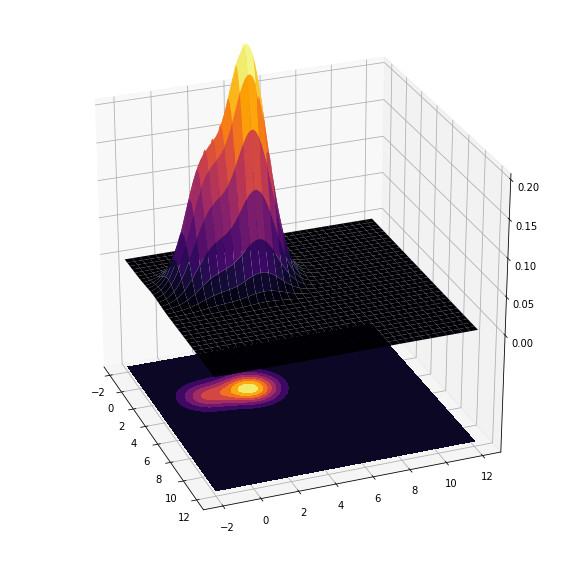

/usr/lib/python3/dist-packages/ipykernel_launcher.py:25: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


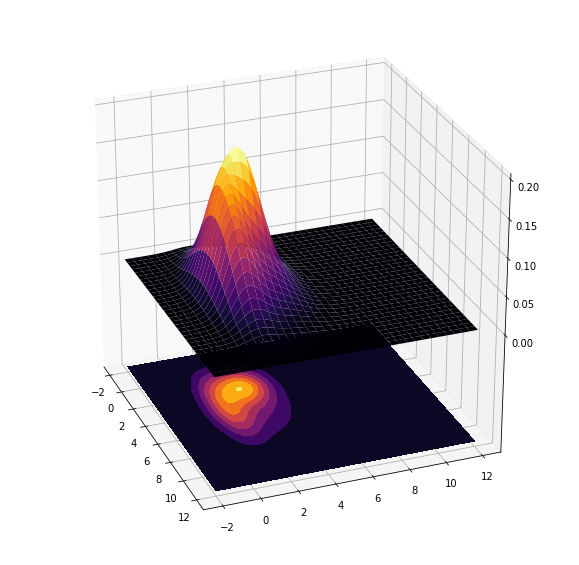

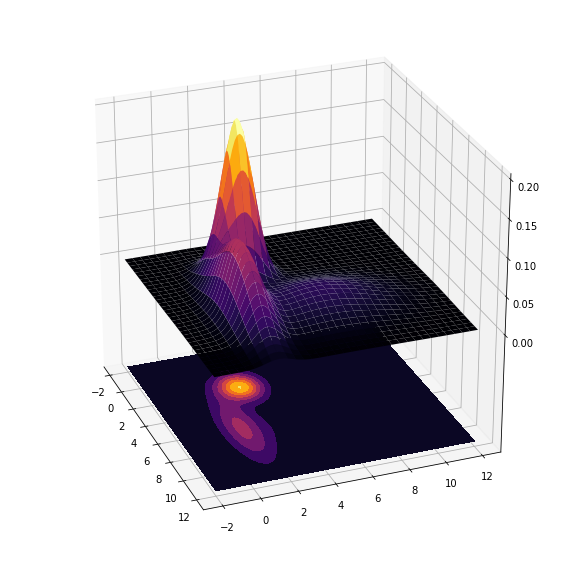

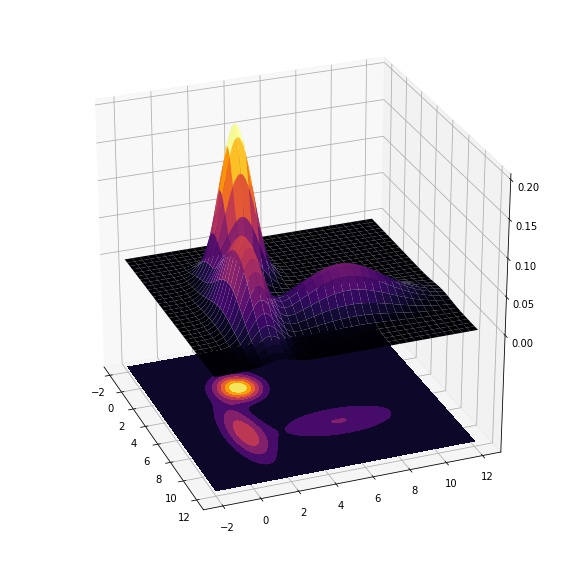

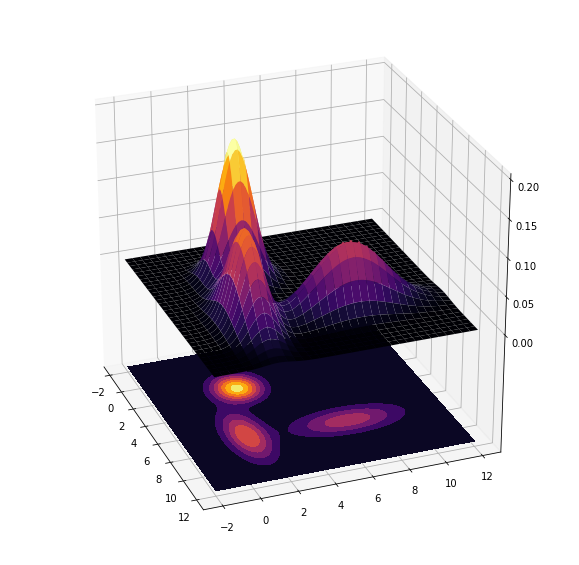

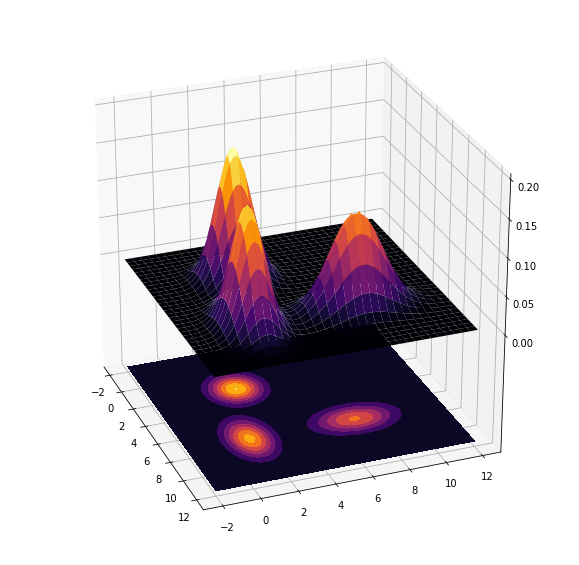

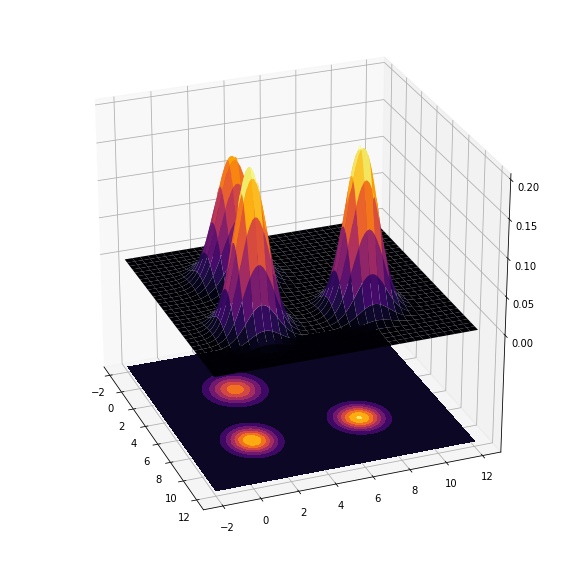

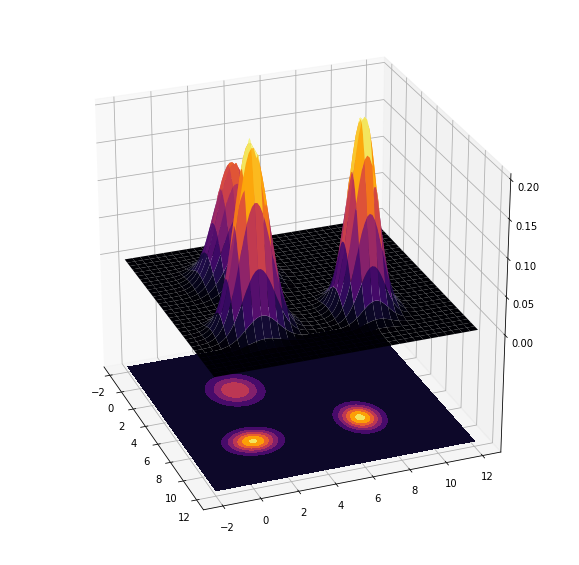

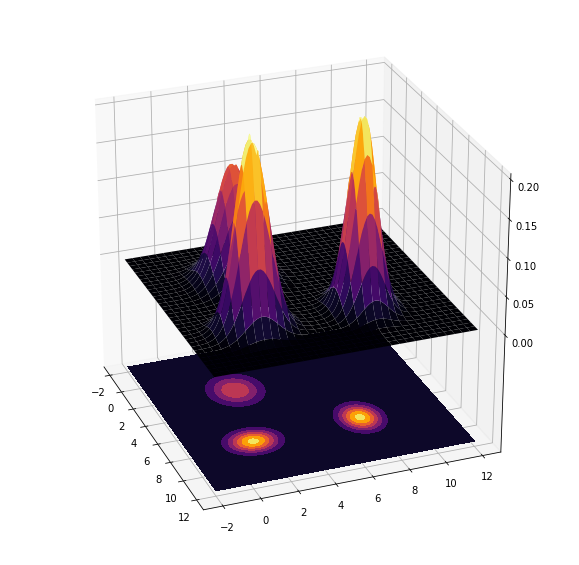

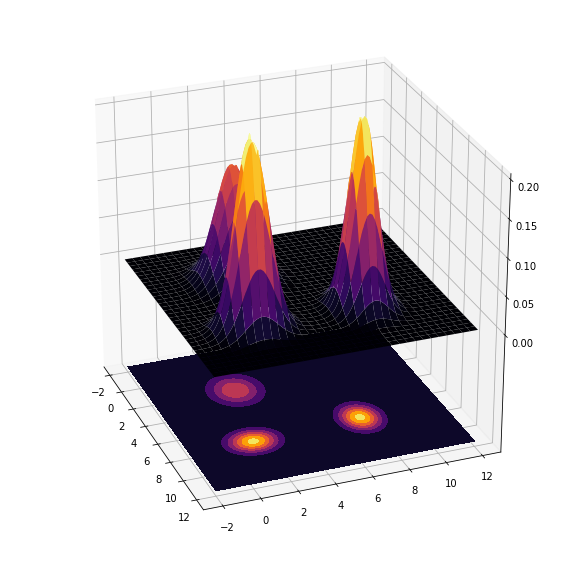

In [16]:
# training loop
k = 3
d = 2
nb_iters = 1000

data = Variable(X)
mu, var, pi = initialize(data, k, var=1)
print(mu.size())

prev_cost = float('inf')
thresh = 1e-4
for i in tqdm(range(nb_iters)):
    # get the likelihoods p(x|z) under the parameters
    P = get_k_likelihoods(data, mu, var)
    
    # plot!
    plot_density(*get_density(mu, var, pi, N=100, X_range=(-2, 12), Y_range=(-2, 12)), i=i)
    
    # compute the "responsibilities" p(z|x)
    gamma = get_posteriors(P)
    
    # compute the cost and check for convergence
    cost = log_likelihood(P, pi)
    diff = prev_cost - cost
    if torch.abs(diff).data[0] < thresh:
        break
    prev_cost = cost
    
    # re-compute parameters
    mu, var, pi = get_parameters(data, gamma)

In [17]:
print(mu)
print(var)
print(pi)

tensor([[ 7.5901,  7.4905],
        [ 7.9695,  1.4504],
        [ 2.4984,  2.4647]])
tensor([[ 0.8089,  0.4875],
        [ 0.5491,  0.7209],
        [ 1.1919,  0.8586]])
tensor([ 0.3333,  0.3336,  0.3331])


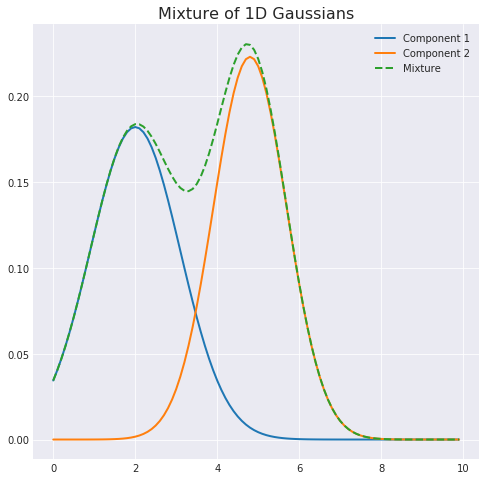

In [18]:
x = np.arange(0, 10, 0.1)
y1 = multivariate_normal.pdf(x, mean=2, cov=1.2)
y2 = multivariate_normal.pdf(x, mean=4.8, cov=0.8)
sns.set_style("darkgrid")
plt.figure(figsize=(8, 8))
plt.plot(x, y1/2, linewidth=2)
plt.plot(x, y2/2, linewidth=2)
plt.plot(x, (y1+y2)/2, linewidth=2, ls="--")
# plt.ylabel('f(x)', fontsize=14)
# plt.xlabel('x', fontsize=14)
plt.title("Mixture of 1D Gaussians", fontsize=16)
plt.legend(['Component 1', 'Component 2', 'Mixture'])
plt.savefig('mixture.png', dpi=400)
plt.show()
# print(a.size())